# Evaluate agent performance across experiments

Using the [MLflow tracking API](https://www.mlflow.org/docs/latest/tracking.html).

In [1]:
%config Completer.use_jedi = False
import os
from pathlib import Path

import mlflow
from mlflow.tracking import MlflowClient

import matplotlib.pyplot as plt

## Get winner counts

Based on runs of `scripts/play.py`

In [2]:
os.chdir(os.environ['RUNS_PARENT_DIR'])
runs = mlflow.search_runs()
mask_winner_isna = runs['metrics.winner_idx'].isna()
runs = runs[~mask_winner_isna]
winner_idxes = runs['metrics.winner_idx'].astype(int)
winner_counts = winner_idxes.value_counts()
names = winner_counts.index
counts = winner_counts.values.astype(int)
winner_counts

1    20
2    20
0    19
3    19
Name: metrics.winner_idx, dtype: int64

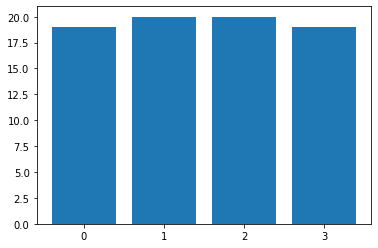

In [3]:
plt.bar(names, counts)
plt.xticks(names, names);